In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def normalize(vector):
    return vector / np.linalg.norm(vector)

def reflected(vector, axis):
    return vector - 2 * np.dot(vector, axis) * axis

def sphere_intersect(center, radius, ray_origin, ray_direction):
    b = 2 * np.dot(ray_direction, ray_origin - center)
    c = np.linalg.norm(ray_origin - center) ** 2 - radius ** 2
    delta = b ** 2 - 4 * c
    if delta > 0:
        t1 = (-b + np.sqrt(delta)) / 2
        t2 = (-b - np.sqrt(delta)) / 2
        if t1 > 0 and t2 > 0:
            return min(t1, t2)
    return None

def nearest_intersected_object(objects, ray_origin, ray_direction):
    distances = [sphere_intersect(obj['center'], obj['radius'], ray_origin, ray_direction) for obj in objects]
    nearest_object = None
    min_distance = np.inf
    for index, distance in enumerate(distances):
        if distance and distance < min_distance:
            min_distance = distance
            nearest_object = objects[index]
    return nearest_object, min_distance


In [3]:
width = 900
height = 600

max_depth = 3

camera = np.array([0, 0, 1])
ratio = float(width) / height
screen = (-1, 1 / ratio, 1, -1 / ratio)  # left, top, right, bottom

light = { 'position': np.array([5, 5, 5]), 'ambient': np.array([1, 1, 1]), 'diffuse': np.array([1, 1, 1]), 'specular': np.array([1, 1, 1]) }

objects = [
    { 'center': np.array([-0.5, 0.1, -1]), 'radius': 0.5, 'ambient': np.array([0.05, 0.05, 0.05]), 'diffuse': np.array([0.7, 0.1, 0.2]), 'specular': np.array([1, 1, 1]), 'shininess': 50, 'reflection': 0.3 },
    { 'center': np.array([0.2, -0.3, -1.5]), 'radius': 0.3, 'ambient': np.array([0.05, 0.05, 0.05]), 'diffuse': np.array([0.1, 0.7, 0.3]), 'specular': np.array([1, 1, 1]), 'shininess': 50, 'reflection': 0.4 },
    { 'center': np.array([0.8, 0.5, -2]), 'radius': 0.7, 'ambient': np.array([0.05, 0.05, 0.05]), 'diffuse': np.array([0.1, 0.2, 0.7]), 'specular': np.array([1, 1, 1]), 'shininess': 50, 'reflection': 0.5 },
    { 'center': np.array([0, -9000, 0]), 'radius': 9000 - 0.7, 'ambient': np.array([0.1, 0.1, 0.1]), 'diffuse': np.array([0.6, 0.6, 0.6]), 'specular': np.array([1, 1, 1]), 'shininess': 100, 'reflection': 0.1 }
]


Linhas renderizadas: 100/600
Linhas renderizadas: 200/600
Linhas renderizadas: 300/600
Linhas renderizadas: 400/600
Linhas renderizadas: 500/600
Linhas renderizadas: 600/600


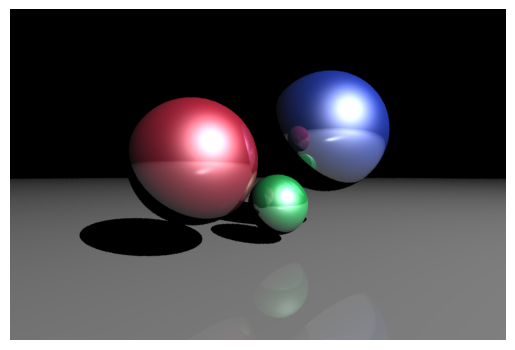

In [4]:
def render_scene(objects, light, camera, screen, width, height, max_depth):
    image = np.zeros((height, width, 3))
    samples = 4  # Número de amostras para anti-aliasing

    for i, y in enumerate(np.linspace(screen[1], screen[3], height)):
        for j, x in enumerate(np.linspace(screen[0], screen[2], width)):
            color = np.zeros((3))
            for s in range(samples):
                pixel_x = x + np.random.uniform(-1, 1) / width
                pixel_y = y + np.random.uniform(-1, 1) / height
                pixel = np.array([pixel_x, pixel_y, 0])
                origin = camera
                direction = normalize(pixel - origin)

                reflection = 1
                for _ in range(max_depth):
                    nearest_object, min_distance = nearest_intersected_object(objects, origin, direction)
                    if nearest_object is None:
                        break

                    intersection = origin + min_distance * direction
                    normal_to_surface = normalize(intersection - nearest_object['center'])
                    shifted_point = intersection + 1e-5 * normal_to_surface
                    intersection_to_light = normalize(light['position'] - shifted_point)

                    _, min_distance = nearest_intersected_object(objects, shifted_point, intersection_to_light)
                    intersection_to_light_distance = np.linalg.norm(light['position'] - intersection)
                    is_shadowed = min_distance < intersection_to_light_distance

                    if is_shadowed:
                        break

                    illumination = np.zeros((3))
                    illumination += nearest_object['ambient'] * light['ambient']
                    illumination += nearest_object['diffuse'] * light['diffuse'] * np.dot(intersection_to_light, normal_to_surface)

                    intersection_to_camera = normalize(camera - intersection)
                    H = normalize(intersection_to_light + intersection_to_camera)
                    specular_intensity = np.dot(normal_to_surface, H)
                    if specular_intensity > 0:
                        illumination += nearest_object['specular'] * light['specular'] * (specular_intensity ** (nearest_object['shininess'] / 4))

                    color += reflection * illumination
                    reflection *= nearest_object['reflection']

                    origin = shifted_point
                    direction = reflected(direction, normal_to_surface)

            image[i, j] = np.clip(color / samples, 0, 1)
        if (i + 1) % 100 == 0:
            print(f"Linhas renderizadas: {i + 1}/{height}")

    return image

image = render_scene(objects, light, camera, screen, width, height, max_depth)
plt.imshow(image)
plt.axis('off')
plt.show()



In [5]:
plt.imsave('ray_traced_image.png', image)
